**DATA ANALYSIS**

In [91]:
import pandas as pd
import numpy as np
import io
import requests
import os
import zipfile
import urllib.request
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import PercentFormatter #plot as percentage
import seaborn #plot density and histogram at the same time
# Set directory where files are downloaded to. Chdir has to be changed in order to run on another computer
os.chdir('C:\\Users\justu\\Desktop\\Masterarbeit\\Data\\CE') #change this to the folder where the data set is stored, all the results will be saved in the same folder
os.getcwd()

'C:\\Users\\justu\\Desktop\\Masterarbeit\\Data\\CE'

**Prepare Data** (necessary for part1 and part2)

In [95]:
fs08 = pd.read_csv(os.getcwd()+'\\fs08.csv').set_index('CustID')
#identifier
TIME = ['QINTRVMO', 'QINTRVYR']
ID = ['NEWID']

#dependent variables
CONS = ['FD','SND','ND','DUR']
#CHGCONS = ['chg_' + var for var in CONS]
#LAGCONS = ['last_' + var for var in CONS]


#explanatory variables
DEMO = ['age', 'adults', 'PERSLT18', 'MARITAL1', 'CUTENURE', 'FINCBTAX'] 
    #age; number of adults; people below 18; marital status; housing tenure; income in the last 12 months
DEMO2 = ['FSALARYM', 'FINCBTXM'] 
    #FSALARYM: income from salary and wages, CKBKACTX: balance/market value in balance accounts/brookerage accounts;    
    #FINCBTXM: Total amount of family income before taxes (Imputed or collected data); (relevant demographics available for the second stimulus only)
ASSETS = ['valid_finassets','finassets']
    # finassets: sum of 1) SAVACCTX (Total balance/market value (including interest earned) CU had in savings accounts in banks, savings and loans,
                         #credit unions, etc., as of the last day of previous month;)
                # and    2)CKBKACTX (Total balance or market value (including interest earned) CU had in checking accounts, brokerage accounts, 
                            #and other similar accounts as of the last day of the previous month
MORTGAGE = ['morgpayment', 'qblncm1x_sum', 'orgmrtx_sum', 'qescrowx_sum', 'timeleft']
    #morgpayment: morgage payment per month; qblncm1x_sum: sum of principal balances outstanding at the beginning of month M1; orgmrtx_sum: sum of mortgage amounts;
    #qescrowx_sum: sum of last regular escrow payments; timeleft: maximum time left on mortgage payment

#sample split
RBT = ['rbtamt', 'rbtamt_chk', 'rbtamt_e']
LAGRBT = ['last_' + var for var in RBT] #lagged variables
FUTRBT = ['fut_' + var for var in RBT] #future variables

fs08 = fs08[TIME + ID + CONS + DEMO + DEMO2 + ASSETS + MORTGAGE + RBT + LAGRBT + FUTRBT] #+ CHGCONS + LAGCONS 
fs08 = pd.get_dummies(fs08, columns=['CUTENURE']) #change categorical variables to dummy variables
DEMO = [s for s in DEMO if s != 'CUTENURE'] + ['CUTENURE' + f'_{j}' for j in list(range(1,6)) if j!=3]

In [93]:
print(fs08['FINCBTAX'].corr(fs08['FINCBTXM']))
print(fs08['FSALARYM'].corr(fs08['FINCBTXM']))
print(fs08['FSALARYM'].corr(fs08['FINCBTAX']))
print(fs08['FINCBTAX'].corr(fs08['morgpayment']))
print(fs08.loc[(fs08['rbtamt']>0)&(fs08['valid_finassets']>0),'NEWID'].count())
print(fs08.loc[fs08['rbtamt']>0,'NEWID'].count())

0.8287701228524802
0.8955169267751125
0.7627057548315713
0.09380920937886113
771
4339


Generate the average rebate amount per individual 

In [96]:
fs08['rbtamt_idmean'] = 0
fs08['rbtamt_idmean'] = fs08.groupby('CustID')['rbtamt'].transform('mean')
fs08['rbt_count'] = 0
fs08['rbt_count'] = fs08.groupby('CustID')['rbtamt'].transform('count')

#
#sometimes individuals give information of rebate receipt preceding (following) three months of the first (last) interview.
#Wherever this is the case, the average rebate should be the weighted mean of rebates received before (after) the relevant time and the actual rebate 

fs08['rbtamt_idmean'] = np.where((fs08['last_rbtamt']>0) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].first())),
                                 1/(1+fs08['rbt_count'])*(fs08['last_rbtamt']+fs08['rbtamt_idmean']), fs08['rbtamt_idmean']) #weighted mean,  & (fs08['rbtamt_idmean']>0)
index = fs08.index[(fs08['last_rbtamt']>0) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].first()))].tolist() # & (fs08['rbtamt_idmean']>0)
fs08.loc[index,'rbtamt_idmean'] = fs08.loc[index,:].groupby('CustID')['rbtamt_idmean'].transform('first') #change for all entries for a given individual


fs08['rbtamt_idmean'] = np.where((fs08['fut_rbtamt']>0) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].last())),
                                 1/(1+fs08['rbt_count'])*(fs08['fut_rbtamt']+fs08['rbtamt_idmean']), fs08['rbtamt_idmean']) #weighted mean  & (fs08['rbtamt_idmean']>0)
index = fs08.index[(fs08['fut_rbtamt']>0)  & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].last()))].tolist() #& (fs08['rbtamt_idmean']>0)
fs08.loc[index,'rbtamt_idmean'] = fs08.loc[index,:].groupby('CustID')['rbtamt_idmean'].transform('last')  #change for all entries for a given individual
#display(fs08.loc[index, ['rbtamt_idmean', 'rbtamt', 'fut_rbtamt', 'last_rbtamt']])

#wherever there is no entry for rebates received in the relevant time period but when there were rebates receivde in the past (future) change mean to the value
index = fs08.index[(fs08['fut_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].last()))].tolist() #                                                                               
fs08['rbtamt_idmean'] = np.where((fs08['fut_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].last())),
                                 fs08['fut_rbtamt'], fs08['rbtamt_idmean'])
fs08.loc[index,'rbtamt_idmean'] = fs08.loc[index,:].groupby('CustID')['rbtamt_idmean'].transform('last')

index = fs08.index[(fs08['last_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].first()))].tolist()
fs08['rbtamt_idmean'] = np.where((fs08['last_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].first())), 
                                fs08['last_rbtamt'], fs08['rbtamt_idmean'])
fs08.loc[index,'rbtamt_idmean'] = fs08.loc[index,:].groupby('CustID')['rbtamt_idmean'].transform('first')


fs08['rbt_flag'] = 0 
fs08.loc[(fs08['rbtamt']>0) | (fs08['fut_rbtamt']>0) | (fs08['last_rbtamt']>0) ,'rbt_flag'] = 1
fs08['rbt_flag'] = fs08.groupby('CustID')['rbt_flag'].transform('sum')
fs08.loc[fs08['rbt_flag']>0, 'rbt_flag'] = 1
fs08 = fs08.loc[fs08['rbt_flag']==1]


index = fs08.index[fs08['rbtamt_idmean'].isna()].tolist()
index = list(set(index))
fs08.loc[index, 'rbtamt_idmean'] = fs08.loc[index,'fut_rbtamt']
fs08.loc[(fs08['fut_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()), 'rbtamt_idmean' ] = fs08.loc[(fs08['fut_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()), 'fut_rbtamt' ]
fs08.loc[(fs08['last_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()), 'rbtamt_idmean' ] = fs08.loc[(fs08['last_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()), 'last_rbtamt' ]

fs08.loc[index,'rbtamt_idmean'] = fs08.loc[index,:].groupby('CustID')['rbtamt_idmean'].transform('mean')

print('some descriptives for the average amount of rebate received per household')
print(fs08.loc[fs08['rbtamt_idmean'].notna(),'rbtamt_idmean'].describe())

some descriptives for the average amount of rebate received per household
count    16218.000000
mean       967.854791
std        512.280653
min          6.000000
25%        600.000000
50%        900.000000
75%       1200.000000
max       3660.000000
Name: rbtamt_idmean, dtype: float64


QINTRVMO           0
QINTRVYR           0
NEWID              0
FD                 0
SND                0
ND                 0
DUR                0
age                0
adults             0
PERSLT18           0
MARITAL1           0
FINCBTAX           0
FSALARYM           0
FINCBTXM           0
valid_finassets    0
finassets          0
morgpayment        0
qblncm1x_sum       0
orgmrtx_sum        0
qescrowx_sum       0
timeleft           0
rbtamt             0
rbtamt_chk         0
rbtamt_e           0
last_rbtamt        0
last_rbtamt_chk    0
last_rbtamt_e      0
fut_rbtamt         0
fut_rbtamt_chk     0
fut_rbtamt_e       0
CUTENURE_1         0
CUTENURE_2         0
CUTENURE_4         0
CUTENURE_5         0
rbtamt_idmean      0
rbt_count          0
rbt_flag           0
dtype: int64

Drop observations, impute values for financial liquidity

In [22]:

#index1 = fs08.index[fs08['rbtamt_idmean'].isna()].tolist()
fs08.loc[index1,['rbtamt_idmean', 'rbtamt', 'fut_rbtamt', 'last_rbtamt']]

,rbtamt_idmean,rbtamt,fut_rbtamt,last_rbtamt
CustID,,,,
183858,NaN,NaN,NaN,NaN
183858,NaN,NaN,NaN,NaN
183858,NaN,NaN,NaN,NaN
183858,900.0,NaN,900.0,NaN
183858,NaN,NaN,NaN,NaN
183858,NaN,NaN,NaN,NaN
183858,NaN,NaN,NaN,NaN
183858,900.0,NaN,900.0,NaN
183858,NaN,NaN,NaN,NaN


In [5]:


for i in range(len(RBT)):
    fs08.loc[fs08[RBT[i]]==0, RBT[i]] = np.nan
    fs08.loc[fs08[LAGRBT[i]]==0, LAGRBT[i]] = np.nan
    fs08.loc[fs08[FUTRBT[i]]==0, FUTRBT[i]] = np.nan
    #fs08.loc[(fs08[LAGRBT[i]]==0) | (fs08[LAGRBT[i]].isna()), LAGRBT[i]] =  fs08.loc[(fs08[LAGRBT[i]]==0) | (fs08[LAGRBT[i]].isna())].groupby('CustID')[RBT[i]].shift(-1) 
    fs08.loc[(fs08[FUTRBT[i]]==0) | (fs08[FUTRBT[i]].isna()), FUTRBT[i]] =  fs08.loc[(fs08[FUTRBT[i]]==0) | (fs08[FUTRBT[i]].isna())].groupby('CustID')[RBT[i]].shift(-1) 



fs08 = fs08.reset_index()

#Iterative imputation for financial liquidity
#explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer


fs08 = fs08.dropna(subset=CONS+DEMO+DEMO2+MORTGAGE) #Keep only observations that have all info on explanatory variables, dropping missing values on mortgage lowers the sample to half 


fs08_finit = fs08.copy()
labels = list(fs08_finit.columns)
imp_mean = IterativeImputer(random_state=0) #use python package iterative imputer
imp_mean.fit(fs08_finit)
fs08_finit = pd.DataFrame(imp_mean.transform(fs08_finit),columns=labels)
fs08_finit = fs08_finit.loc[:,['finassets','NEWID']]
fs08_finit = fs08_finit.rename(columns={'finassets':'finassets_it'})

fs08 = pd.merge(fs08.sort_values(by = ['NEWID']).reset_index(), fs08_finit.sort_values(by = ['NEWID']).reset_index(), how = 'left', on = 'NEWID', validate = '1:1')
fs08 = fs08.drop(columns=['index_x','index_y']) 
ASSETS = ['valid_finassets','finassets', 'finassets_it' ]

In [14]:
print(fs08.loc[fs08['rbtamt_idmean'].notna(),'rbtamt_idmean'].count())


7275


0       183858
1       183858
2       183858
12      183941
13      183941
14      183941
20      183954
21      183954
22      183954
45      184037
46      184037
47      184037
53      184054
54      184054
55      184054
137     184641
138     184641
139     184641
149     184697
150     184697
151     184697
160     184786
161     184786
162     184786
168     184806
169     184806
170     184806
188     184875
189     184875
190     184875
         ...  
7853    197122
7854    197122
7855    197138
7856    197138
7857    197150
7858    197150
7859    197151
7860    197151
7869    197215
7870    197215
7873    197217
7874    197217
7877    197223
7878    197223
7879    197229
7880    197229
7881    197233
7882    197233
7887    197245
7888    197245
7889    197246
7890    197246
7891    197276
7892    197276
7893    197287
7894    197287
7897    197299
7898    197299
7899    197311
7900    197311
Name: CustID, Length: 626, dtype: int64

Generate treatment and control groups

In [6]:
#generate treatment group:
fs08['treat'] = 0 
fs08.loc[fs08['rbtamt'].notna(),'treat'] = 1 #all entries with actual info on rebate are in the treatment group

#three different control groups:
#control group 1: those who didn't receive the rebate in the given month
fs08['cont1'] = 0
fs08.loc[fs08['rbtamt'].isna(), 'cont1'] = 1

#control group 2: drop one time period after receipt of rebate, as part of rebate might've been consumed one time period after
fs08['cont2'] = 0 
fs08['rbt_flag'] = 0 
fs08.loc[fs08['rbtamt']>0,'rbt_flag'] = 1 #identifier for rebate
fs08['rbt_flag_lag'] = fs08.groupby('CustID')['rbt_flag'].shift(1) #identifier for rebate a period before (lag)
fs08.loc[fs08['rbt_flag_lag']==1,'rbt_flag']=1 #change rebate identifier so it capture now if a rebate was received this period or the period before
fs08.loc[(fs08['rbtamt'].isna()) & (fs08['rbt_flag']==0), 'cont2'] = 1 #those who didn't receive a rebate now or a period before are in the control group

#control group 3: only those who have not received the rebate yet
fs08['cont3'] = 0 
fs08['rbt_flag'] = fs08.groupby('CustID')['rbt_flag'].transform('cumsum') #starts counting from the point on which the first rebate was received
fs08.loc[(fs08['rbtamt'].isna()) & (fs08['rbt_flag']==0),'cont3'] = 1 

Drop observations

In [7]:
fs08_cap = fs08[(np.abs(stats.zscore(fs08.loc[:,CONS])) < 3).all(axis=1)] #drop outliers

**Part 1: Descriptive statistics** (part 1 and part 2 cn be run seperately)

1.1 Descriptives for dependent variable

In [11]:
print('summary stats for full sample on consumption:')
print(fs08_cap[CONS].describe())
print('summary stats for capped sample on consumption:')
print(fs08_cap[CONS].describe())

for group in ['treat','cont1','cont2','cont3']:
    print('summary stats for', group, 'on consumption:')
    print(fs08_cap.loc[fs08_cap[group]==1,CONS].describe())

summary stats for full sample on consumption:
                 FD           SND            ND           DUR
count   7901.000000   7901.000000   7901.000000   7901.000000
mean    2214.125173   5107.249167   6357.100416   6241.762099
std     1309.135172   2681.752964   3277.032339   5821.221010
min        0.000000    611.000100  -4420.575000    169.499900
25%     1371.000000   3415.000200   4204.999800   3099.000200
50%     1975.000200   4620.750200   5761.999900   4756.000200
75%     2750.000100   6157.000000   7722.000200   7262.999900
max    37678.000300  50375.052100  54477.052200  90264.999900
summary stats for capped sample on consumption:
                FD           SND            ND           DUR
count  7529.000000   7529.000000   7529.000000   7529.000000
mean   2099.233895   4837.167030   6032.521091   5464.395464
std    1017.443861   2006.819885   2561.928616   3556.470829
min       0.000000    611.000100    876.250100    169.499900
25%    1361.999600   3371.999900   4155.500

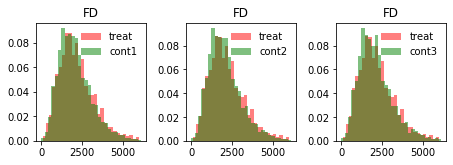

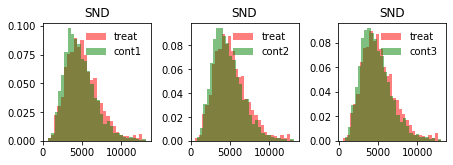

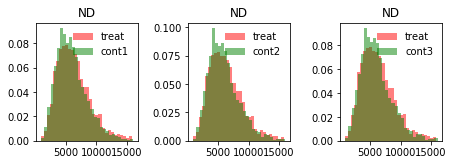

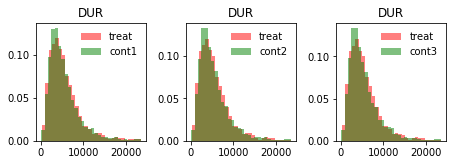

In [175]:
#compare histograms of treatment group with different control groups
control = ['cont1','cont2','cont3']
plot_count = 1
for i in range(len(CONS)):
    plt.figure(figsize=(6.4,2.4))
    for cont in control:
        plot = plt.subplot(1,3,control.index(cont)+1)
        plot.hist(fs08_cap.loc[fs08_cap['treat']==1,CONS[i]], alpha=0.5, label= 'treat', weights=np.ones(len(fs08_cap.loc[fs08_cap['treat']==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap['treat']==1,CONS[i]]), bins=30, color='red')
        plot.hist(fs08_cap.loc[fs08_cap[cont]==1,CONS[i]], alpha=0.5, label= cont, weights=np.ones(len(fs08_cap.loc[fs08_cap[cont]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[cont]==1,CONS[i]]), bins=30, color='green')
        plot.set_title(CONS[i])
        plt.tight_layout()
        plt.legend(loc='upper right', frameon=False)
        plot_count = plot_count+1
    plt.savefig(os.getcwd() + f'\\descriptives\\cons{CONS[i]}_pattern.pdf')
    plt.show()


1.2 Take a look at the explanatory variables used for random forest algorithm

In [40]:
print('Whole sample (capped):')
print(fs08_cap.loc[:,DEMO+DEMO2+ASSETS+MORTGAGE].describe())
for group in ['treat','cont1','cont2','cont3']:
    print('----------------------------------------------')
    print(group, '(capped):')
    print(fs08_cap.loc[fs08_cap[group]==1,DEMO+DEMO2+ASSETS+MORTGAGE].describe())

for group in ['treat','cont1','cont2','cont3']:
    print('----------------------------------------------')
    print(group, '(capped) solely on liquid assets:')
    print(fs08_cap.loc[fs08_cap[group]==1, ASSETS].describe() )

Whole sample (capped):
               age       adults     PERSLT18     MARITAL1       FINCBTAX  \
count  7529.000000  7529.000000  7529.000000  7529.000000    7529.000000   
mean     46.667021     2.077434     0.923363     1.772745   67916.802895   
std      12.237435     0.779985     1.178017     1.355910   51808.723566   
min      21.000000     1.000000     0.000000     1.000000 -104854.000000   
25%      37.500000     2.000000     0.000000     1.000000   32300.000000   
50%      46.000000     2.000000     0.000000     1.000000   62078.000000   
75%      55.000000     2.000000     2.000000     3.000000   97000.000000   
max      84.500000     7.000000     8.000000     5.000000  434017.000000   

        CUTENURE_1   CUTENURE_2   CUTENURE_4   CUTENURE_5       FSALARYM  \
count  7529.000000  7529.000000  7529.000000  7529.000000    7529.000000   
mean      0.977952     0.010891     0.010094     0.001063   71904.573064   
std       0.146850     0.103798     0.099969     0.032582   5196

**Part 2: Machine learning approach**

**2.1** Define sample 

In [8]:
expvars = DEMO + DEMO2 + MORTGAGE  #define explanatory variables + ['finassets_it'] 
depvar = 'SND' #define dependent variable
contgroup = 'cont1'
finasset = False
valid_finasset = False

if (finasset == True) & (valid_finasset == True):
    expvars = expvars +  ['finassets']
    treat = fs08_cap.loc[(fs08_cap['treat']==1) & (fs08_cap['valid_finassets']==1), [depvar] + expvars + ['rbtamt_idmean']] #define treatment sample .dropna(subset=['finassets_it'])
    cont = fs08_cap.loc[(fs08_cap[contgroup]==1) & (fs08_cap['valid_finassets']==1), [depvar] + expvars + ['rbtamt_idmean']] #define control variable .dropna(subset=['finassets_it'])
    pathend = depvar + '_' + contgroup + '_fin'
    print(pathend)
elif (finasset == True) & (valid_finasset == False):
    expvars = expvars +  ['finassets_it']
    treat = fs08_cap.loc[(fs08_cap['treat']==1), [depvar] + expvars + ['rbtamt_idmean']] #define treatment sample .dropna(subset=['finassets_it'])
    cont = fs08_cap.loc[(fs08_cap[contgroup]==1), [depvar] + expvars +['rbtamt_idmean']] #define control variable .dropna(subset=['finassets_it'])
    pathend = depvar + '_' + contgroup + '_finit'
    print(pathend)
elif (finasset == False) & (valid_finasset == False): 
    treat = fs08_cap.loc[(fs08_cap['treat']==1), [depvar] + expvars +['rbtamt_idmean']] #define treatment sample .dropna(subset=['finassets_it'])
    cont = fs08_cap.loc[(fs08_cap[contgroup]==1), [depvar] + expvars +['rbtamt_idmean']] #define control variable .dropna(subset=['finassets_it'])
    pathend = depvar + '_' + contgroup + '_nofin'
    print(pathend)
else:
    print('CHECK IF FINASSET OR VALID_FINASSET IS CORRECTLY SPECIFIED')


SND_cont1_nofin


In [12]:
cont.loc[cont['rbtamt_idmean'].isna()].count()
#treat['rbtamt_idmean']

SND              602
age              602
adults           602
PERSLT18         602
MARITAL1         602
FINCBTAX         602
CUTENURE_1       602
CUTENURE_2       602
CUTENURE_4       602
CUTENURE_5       602
FSALARYM         602
FINCBTXM         602
morgpayment      602
qblncm1x_sum     602
orgmrtx_sum      602
qescrowx_sum     602
timeleft         602
rbtamt_idmean      0
dtype: int64

**2.2** Run random forest algorithm seperately for treatment and control group

In [9]:
rf = {'treat': treat, 'cont': cont} #dict for treatment and control data ready for random forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

for i in ['treat','cont']: #
    y = np.array(rf[i][depvar]) #array for dependent variable
    X = np.array(rf[i][expvars]) #array with relevant explanatory variables as columns
    rf[i+'_X'] = X #save as dict entry with keyword treat_X/cont_X
    X_labels = list(rf[i][expvars].columns) #column labels as list
    rf[i+'_X_labels'] = X_labels #save in dict
    rf[i+'_rbtamt'] = np.array(rf[i]['rbtamt_idmean'])
    #train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.25, random_state = 42)
    print(f'for {i} data:'.upper()) 
    print('dependent variable training data shape:', y.shape) #make sure shape is correct
    print('explanatory variables training data shape:', X.shape) 
    #instantiate model with 1000 decision trees, and third of explanatory varibales, also save oob_score
    rf[i+'_rf'] = RandomForestRegressor(n_estimators = 1000, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
    rf[i+'_rf'].fit(X,y)
    print(f'Oob score:')
    print(rf[i+'_rf'].oob_score_)
    print('Score')
    print(rf[i+'_rf'].score(X, y))
    predictions = rf[i+'_rf'].predict(X)
    errors = abs(predictions - y)
    oob_errors = abs(rf[i+'_rf'].oob_prediction_ - y) #take variables that were not part in calculation of random forest due to bootstrapping
    print('Mean Absolute Error:', round(np.mean(errors),2),'dollars')
    print('Mean Absolute Oob Error:', round(np.mean(oob_errors),2),'dollars')
    #calculate mean absolute percentage error (MAPE)
    mape = 100*(errors/y)
    oob_mape = 100*(oob_errors/y)
    #Calculate and display accuray
    accuracy = 100 - np.mean(mape)
    oob_accuracy = 100 - np.mean(oob_mape)
    print('accuracy:', round(accuracy,2),'%')
    print('oob accuracy:', round(oob_accuracy,2),'%')
    importances = rf[i+'_rf'].feature_importances_
    X_importances = [(label, round(importance,2)) for label, importance in zip(X_labels,importances)]
    X_importances = sorted(X_importances, key = lambda x:x[1], reverse = True) #sort by the most important first
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in X_importances]

FOR TREAT DATA:
dependent variable training data shape: (1976,)
explanatory variables training data shape: (1976, 16)
Oob score:
0.3390930280508745
Score
0.6561340006672816
Mean Absolute Error: 922.44 dollars
Mean Absolute Oob Error: 1306.75 dollars
accuracy: 78.64 %
oob accuracy: 69.75 %
Variable: FINCBTXM             Importance: 0.21
Variable: FSALARYM             Importance: 0.19
Variable: FINCBTAX             Importance: 0.12
Variable: adults               Importance: 0.07
Variable: morgpayment          Importance: 0.06
Variable: age                  Importance: 0.05
Variable: PERSLT18             Importance: 0.05
Variable: qblncm1x_sum         Importance: 0.05
Variable: orgmrtx_sum          Importance: 0.05
Variable: qescrowx_sum         Importance: 0.05
Variable: timeleft             Importance: 0.05
Variable: MARITAL1             Importance: 0.04
Variable: CUTENURE_1           Importance: 0.0
Variable: CUTENURE_2           Importance: 0.0
Variable: CUTENURE_4           Importanc

**2.3** Predict Outcomes for overall consumption

In [10]:
def uplift_predicitons(rf_treat, rf_cont, X_treat, X_cont=[], feature_ids_treat=[], feature_ids_cont=[]):
    
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestRegressor
    
    if (type(rf_treat) is not RandomForestRegressor) | (type(rf_cont) is not RandomForestRegressor):
        raise ValueError('rf_treat or rf_cont are not random forest regressors')
    else:
        if (type(X_cont) is not np.ndarray) & (type(X_treat) is np.ndarray):
                    X_temp = X_treat.copy()
        elif (type(X_cont) is np.ndarray) & (type(X_treat) is np.ndarray):
                if sorted(feature_ids_treat)!=sorted(feature_ids_cont):
                    raise ValueError(f'feature_ids_treat needs to be the same as feature_ids_cont')
                elif (len(feature_ids_treat)==0) | (len(feature_ids_cont)==0):
                    raise ValueError(f'if X_treat and X_cont are specified, feature_ids must not be empty')
                else:
                    X = pd.concat([pd.DataFrame(X_treat, columns = feature_ids_cont), pd.DataFrame(X_cont, columns = feature_ids_treat)], join = 'inner', ignore_index=True)
                    X_labels = list(X.columns)
                    X_temp = np.array(X)          
        else: 
            raise ValueError('X_treat does not have an array like structure')
        y = (rf_treat.predict(X_temp) - rf_cont.predict(X_temp))
        return y


In [36]:
y = uplift_predicitons(rf['treat_rf'], rf['cont_rf'], rf['treat_X'], X_cont = rf['cont_X'], 
                                            feature_ids_treat=rf['treat_X_labels'], feature_ids_cont = rf['cont_X_labels'])
 

In [13]:
rbt = pd.concat([pd.DataFrame(rf['treat_rbtamt']), pd.DataFrame(rf['cont_rbtamt'])])
rbt = np.array(rbt)#, join = 'inner', ignore_index=True)
rf['cont_rbtamt']

array([nan, nan, nan, ..., nan, nan, nan])

**2.4** Plot distribution of consumption response

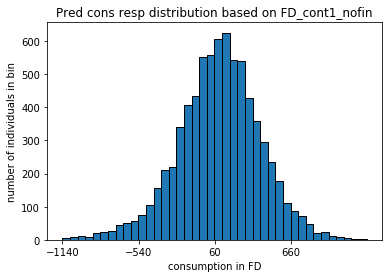

In [28]:
plt.hist(y, bins=40,  edgecolor='black')
lower = round((min(y)/100),1)*100
upper = round((max(y)/100),1)*100+1
plt.xticks(np.arange(lower, upper, 600))
plt.title(f'Pred cons resp distribution based on {pathend}')
plt.xlabel(f'consumption in {depvar}')
plt.ylabel(f'number of individuals in bin')
plt.savefig(os.getcwd() + '\\condistr\\' + pathend +f'.pdf')
plt.show()

**2.5** Variable importance plot for treatment and control group separately and as a weighted sum for the whole sample

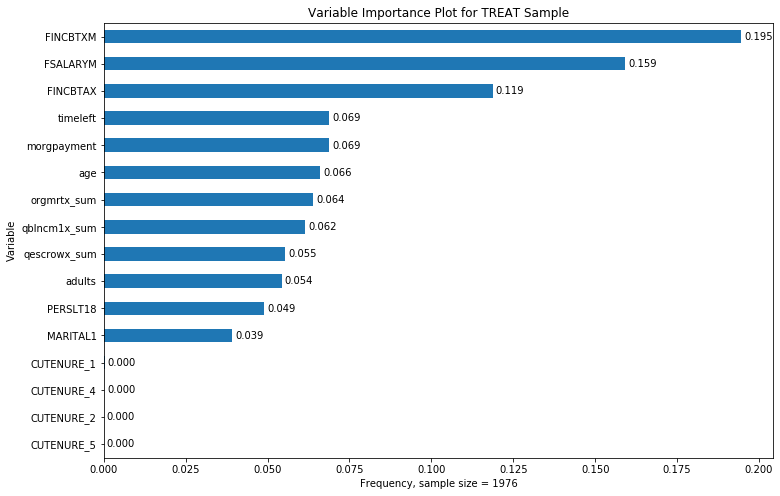

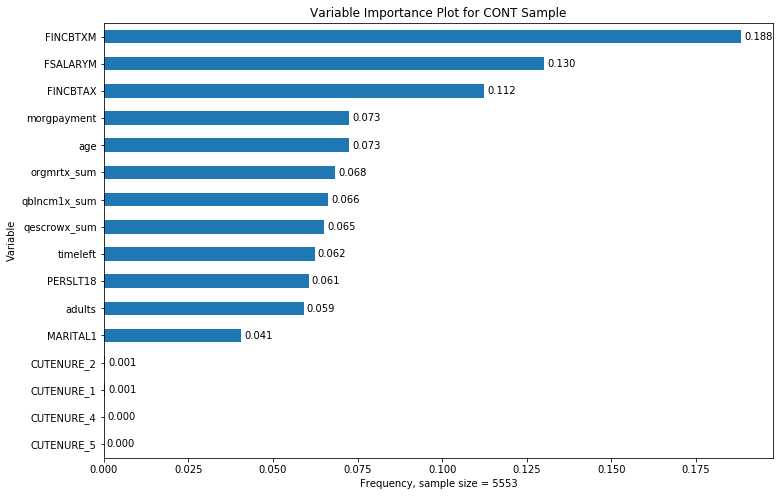

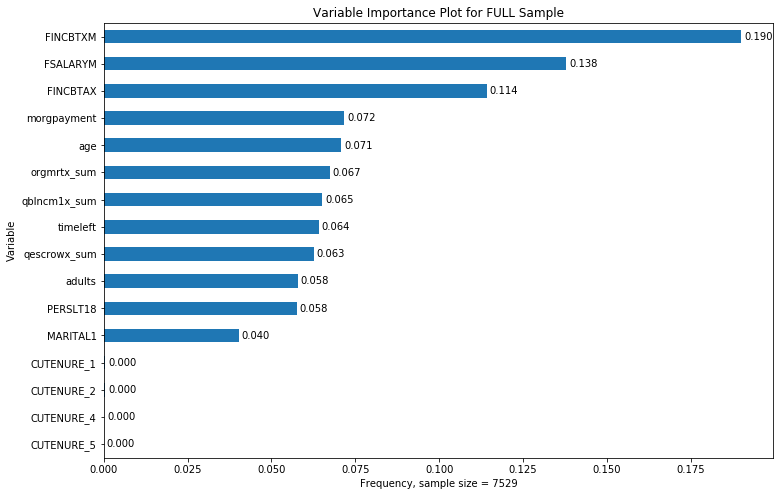

In [29]:
#def vimp_plot_uplift()


newpath = os.getcwd() + '\\varimp\\' + depvar
if not os.path.exists(newpath):
    os.makedirs(newpath)


for i in ['treat','cont']:
    importances = (rf[i+'_rf'].feature_importances_)
    X_importances = [(label, importance) for label, importance in zip(rf[i+'_X_labels'],importances)]
    #X_importances = [(round(importance,2), label) for importance, label in zip(importances, rf[i+'_X_labels'])]
    X_importances = sorted(X_importances, key = lambda x:x[1], reverse = False)
    rf[i+'_varimp_values'] = [x[1] for x in X_importances]
    rf[i+'_varimp_labels'] = [x[0] for x in X_importances]
    rf[i+'_varimp_tuples'] = X_importances

    
uplift_imp = dict()
for i in ['treat','cont']:
    X_importances = sorted(rf[i+'_varimp_tuples'], key = lambda x:x[0].upper(), reverse = False)
    uplift_imp[i+'_values'] =[x[1] for x in X_importances] #importances 
    uplift_imp[i+'_labels'] =[x[0] for x in X_importances] 
    shape=rf[i+'_X'].shape
    uplift_imp[i+'_weight'] =shape[0] 
    
uplift_imp['full_weight'] =  uplift_imp['treat_weight'] + uplift_imp['cont_weight']    
rf['full_varimp_values'] = [uplift_imp['treat_weight']/(uplift_imp['treat_weight']+uplift_imp['cont_weight'])*uplift_imp['treat_values'][i] + 
            uplift_imp['cont_weight']/(uplift_imp['treat_weight']+uplift_imp['cont_weight'])*uplift_imp['cont_values'][i]for i in range(len(uplift_imp['treat_values']))]

up_importances = [(label, importance) for label, importance in zip(uplift_imp['treat_labels'],rf['full_varimp_values'])]
up_importances = sorted(up_importances, key = lambda x:x[1], reverse = False)
rf['full_varimp_values'] = [up[1] for up in up_importances]
rf['full_varimp_labels'] = [up[0] for up in up_importances]
rf['full_varimp_tuples'] = X_importances


#Code to plot extraced from https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
for i in ['treat','cont','full']:
    freq_series = pd.Series(rf[i+'_varimp_values'])
    y_labels = rf[i+'_varimp_labels']

    # Plot the figure.
    plt.figure(figsize=(12, 8))
    ax = freq_series.plot(kind='barh')
    ssize=uplift_imp[i+'_weight']
    ax.set_title(f'Variable Importance Plot for {i.upper()} Sample')
    ax.set_xlabel(f'Frequency, sample size = {str(ssize)}')
    ax.set_ylabel(f'Variable')
    ax.set_yticklabels(y_labels)
    #ax.set_xlim(-40, 300) # expand xlim to make labels easier to read

    rects = ax.patches

    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2

        # Number of points between bar and label. Change to your liking.
        space = 3
        # Vertical alignment for positive values
        ha = 'left'

        # Use X value as label and format number with one decimal place
        label = "{:.3f}".format(x_value)

        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(space, 0),          # Horizontally shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            va='center',                # Vertically center label
            ha=ha)                      # Horizontally align label differently for
                                        # positive and negative values.

    #plt.savefig("image.png")
    plt.savefig(newpath + '\\'+ pathend +f'_{i}.pdf')

**2.6** Partial dependency

**2.6.1** Function for simple partial dependency

In [10]:
def partial_dependency(rf, X, f_id, feature_ids = []): #def partial_dependency(rf, X, y, feature_ids = [], f_id = -1):

    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """

    X_temp = X.copy()
    
    if type(f_id) is int:
        if f_id > (X_temp.shape[1]-1):
            raise ValueError(f'positional number of {f_id} exceeds array shape')
        else:
            column = f_id+1
    elif type(f_id) is str:
        if f_id not in feature_ids:
            raise ValueError(f"explanatory variable {f_id} is not in data frame or feature_ids is not passed to the function")
        else:
            f_id = feature_ids.index(f_id)
    else:
        raise ValueError('f_id needs to be either an integer or a string')
        #return
    
    grid = np.linspace(np.percentile(X_temp[:, f_id], 0.1),
                       np.percentile(X_temp[:, f_id], 99.5),
                       100)
    y_pred = np.zeros(len(grid))
    
    for i, val in enumerate(grid): # i returns the counter, val returns the value at position of counter on grid
        X_temp[:, f_id] = val
        #data = xgb.DMatrix( X_temp[:, feature_ids].reshape( (len(X_temp), len(feature_ids)) ) )
        y_pred[i] = np.average(rf.predict(X_temp)) #any function other than mean is also possible
    return grid, y_pred

**2.6.2** Function for uplift 2model partial dependency

In [11]:
def uplift_2m_partial_dependency(rf_treat, rf_cont, f_id, X_treat, X_cont=[], feature_ids_treat=[], feature_ids_cont=[], types=['mean'], percentile='none', grid_lower=5, grid_upper=95 ): #def partial_dependency(rf, X, y, feature_ids = [], f_id = -1):

    """
    Calculate the partial dependency of response variable on a predictor (or multiple predictors) in a random forest uplift 2 model approach.
    Inputs:
    rf_treat: random forest regressor (from sklearn.ensemble) based on the treatment group (necessary)
    rf_cont: random forest model (from sklearn.ensemble) based on the control group (necessary)
    X_treat: array-like object consisting of all explanatory variables used in the random forest approach (necessary). 
             If X_cont is specified X_treat is assumed to consist only of observations in the treatment group. 
             Otherwise, X_treat is assumed to be the combined observations of control and treatment group.
    X_cont: array-like object consisting of all explanatory variables used in the random forest approach for the control group (optional).
    f_id: string or integer that captures the name or the position of the variable for which the partial dependence is calculated (necessary).
          If f_id is a string, X_cont, feature_ids_treat, and feature_ids_cont need to be specified. 
          If f_id is an integer it captures the positional place of the explanatory variable in the dataframe for which it calculates the partial dependency. 
          If f_id is an integer X_cont, feature_ids_treat, and feature_ids_cont should not be specified bc it cannot be guaranteed that the positions of explanatory variables are the same
          in treatment and control group.
    feature_ids_treat: list of variable names in control group. Index needs to correspond to the position of the variables in X_treat. Needs to be specified if f_id is a string.
    feature_ids_cont: list of variable names in treatment group. Index needs to correspond to the position of the variables in X_cont. Needs to be specified if f_id is a string.
    types: list of different functions for which the variance dependence plot is calculated. 
           Default is 'mean', other options include 'median', 'std' (standard deviation) and 'percentile'.
           If 'percentile' is included in types, percentile input needs to specified.
    percentile: single value that corresponds to the percentile if percentile is included in types 
    grid_lower/grid_upper: The lower and upper percentile used to create the extreme values for the grid. Must be in [0, 1].
    1. Generate a data frame that consists of the combined sample of treatment and control group
    2. Sample a grid of values of a predictor.
    3. For each value, replace every row of that predictor with this value. 
       Calculate the average of the prediction (for the whole sample) between the random forest models of treatment and control group for each grid point. 
    
    Output: 
    grid: grid  of variable for which the partial dependence is calculate (type: ndarray)
    y_pred: corresponding predicted values of dependent variable (type: ndarray). 
            If input types is a list the columns in the array correspond to the chosen types in the same order
    """
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestRegressor
    
    if (type(rf_treat) is not RandomForestRegressor) | (type(rf_cont) is not RandomForestRegressor):
        raise ValueError('rf_treat or rf_cont are not random forest regressors')
    else:
        if type(X_cont) is not np.ndarray:
            if (type(X_treat) is np.ndarray) & (type(f_id) is int):
                if f_id > (X_temp.shape[1]-1):
                    raise ValueError(f'positional number of {f_id} exceeds array shape')
                else:
                    X_temp = X_treat.copy()
            elif (type(X_treat) is np.ndarray) & (type(f_id) is str):
                if f_id not in feature_ids:
                    raise ValueError(f'explanatory variable {f_id} is not in data frame or feature_ids is not passed to the function')
                else:
                    f_id = feature_ids.index(f_id)
                    f_id_label = f_id
                    X_temp = X_treat.copy()
            else:
                raise ValueError('f_id needs to be either an integer or a string')
        elif (type(X_cont) is np.ndarray) & (type(X_treat) is np.ndarray):
            if (type(f_id) is int):
                raise ValueError(f'if X_cont is specified, then f_id needs to be a string variable')
            elif (type(X_treat) is np.ndarray) & (type(f_id) is str) & ((f_id not in feature_ids_treat) |  (f_id not in feature_ids_cont)):
                    raise ValueError(f'explanatory variable {f_id} is not in data frame or feature_ids_treat or feature_ids_cont is not passed to the function')
            else:
                if sorted(feature_ids_treat)!=sorted(feature_ids_cont):
                    raise ValueError(f'feature_ids_treat needs to be the same as feature_ids_cont')
                else:
                    X = pd.concat([pd.DataFrame(X_treat, columns = feature_ids_cont), pd.DataFrame(X_cont, columns = feature_ids_treat)], join = 'inner', ignore_index=True)
                    X_labels = list(X.columns)
                    X_temp = np.array(X)
                    f_id_label = f_id
                    f_id = X_labels.index(f_id)             
        else: 
            raise ValueError('Either X_cont or X_treat does not have an array like structure')

        grid = np.linspace(np.percentile(X_temp[:, f_id], grid_lower),
                           np.percentile(X_temp[:, f_id], grid_upper),
                           100)
        
        nptypes = ['1']*len(types)
        functions = [np.mean,np.std,np.percentile,np.median]
        function_labels = ['mean','std','percentile','median']
        column_labels = types
        
        if set(types) <= set(function_labels):
            for i in range(len(functions)):
                for j in range(len(types)):
                    if function_labels[i] in types[j]:
                        nptypes[j] = functions[i]

            if (np.percentile in nptypes):
                if percentile=='none':
                    raise ValueError('percentile needs to be defined')
                elif not 0<=percentile<=100:
                    raise ValueError('percentile out of range')
                else:
                    pass
        else:
            raise ValueError('types not specified correctly ')

    
        y_pred = np.zeros((len(grid), len(types)))

        for i, val in enumerate(grid): # i returns the counter, val returns the value at position of counter on grid
            X_temp[:, f_id] = val
            y_temp = (rf_treat.predict(X_temp) - rf_cont.predict(X_temp))
            for j in range(len(types)):
                if types[j] == 'percentile':
                    y_pred[i,j] = nptypes[j](y_temp,percentile)
                else:
                    y_pred[i,j] = nptypes[j](y_temp)

        for j in range(len(column_labels)):
            if column_labels[j] == 'percentile':
                column_labels[j] = 'percentile_' + str(percentile)
            else:
                pass       
        column_labels = ['grid']+column_labels
        column_labels = [str(f_id_label)+ '_' + lab for lab in column_labels]

        pd = pd.DataFrame(np.c_[grid, y_pred], columns = column_labels)
        #y_pred = pd.DataFrame(y_pred,columns=types)
        return pd #grid, y_pred y_pred_mean, y_pred_med, y_pred_p90  


Run partial dependence function for given sample and explanatory variables. this may take a while. Hence, save as later as csv

In [30]:
vars = expvars

pdp = uplift_2m_partial_dependency(rf['treat_rf'], rf['cont_rf'], vars[0], rf['treat_X'], rf['cont_X'], 
                                            feature_ids_treat=rf['treat_X_labels'], feature_ids_cont = rf['cont_X_labels'], 
                                             types = ['mean','percentile','std','median'], percentile=30)

for var in vars[1:]:
    pdp = pdp.join(uplift_2m_partial_dependency(rf['treat_rf'], rf['cont_rf'], var, rf['treat_X'], rf['cont_X'], 
                                                feature_ids_treat=rf['treat_X_labels'], feature_ids_cont = rf['cont_X_labels'],                                                 
                                                types = ['mean','percentile','std','median'], percentile=30))

Save data frame as csv

In [31]:
pdp.head()
#%whos DataFrame
pdp.to_csv(os.getcwd() + '\\pdp\\pdp_' + pathend + '.csv') 

Plot partial dependeny as comparison between the different specifications for a given control group and type of consumption

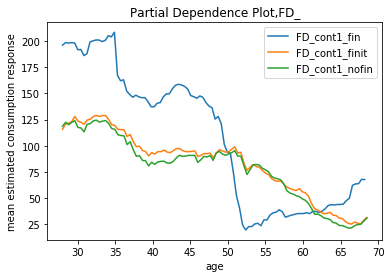

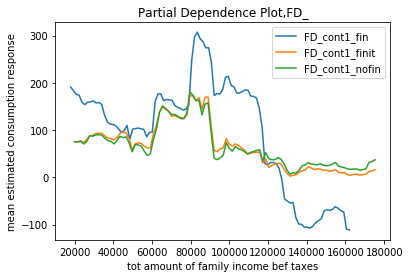

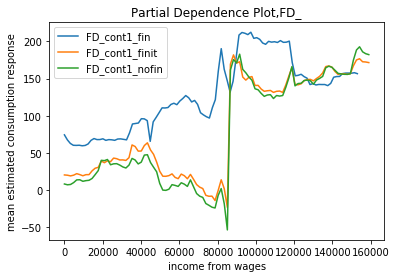

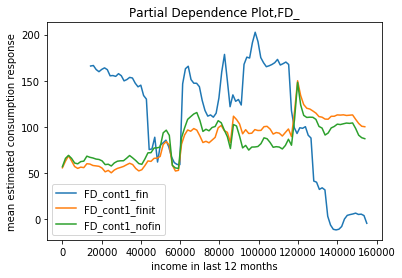

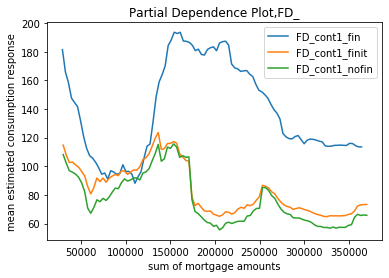

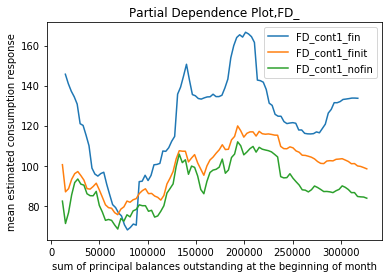

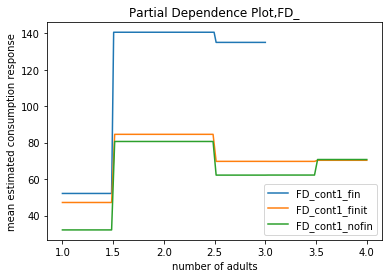

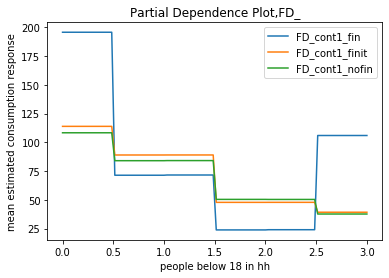

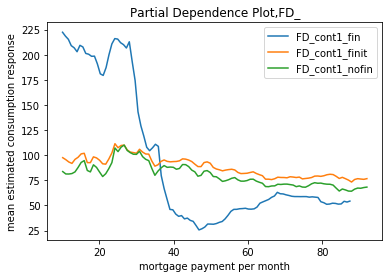

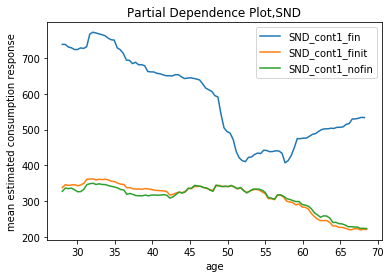

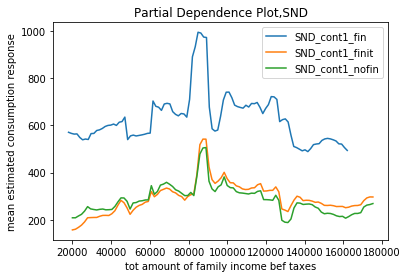

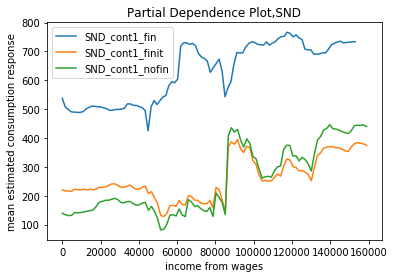

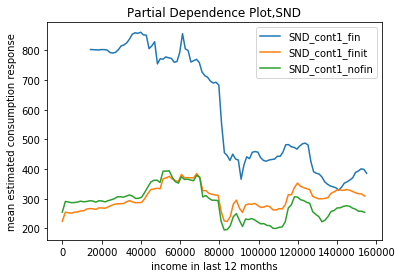

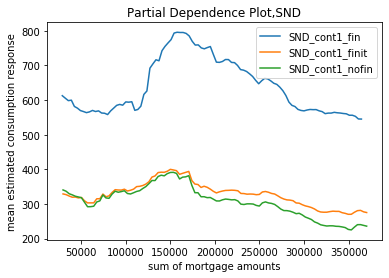

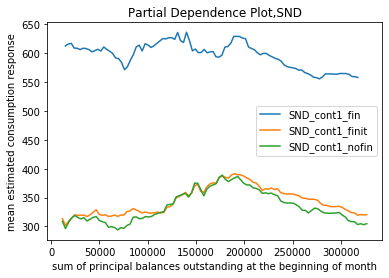

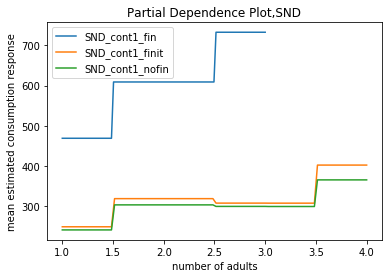

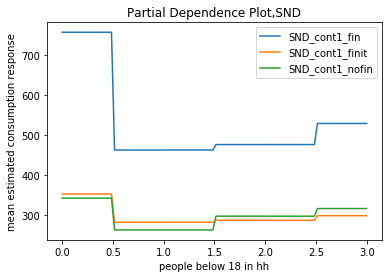

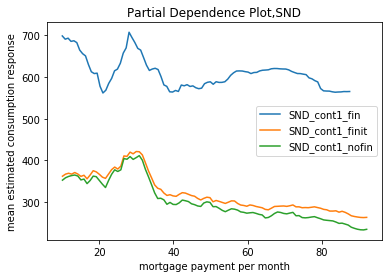

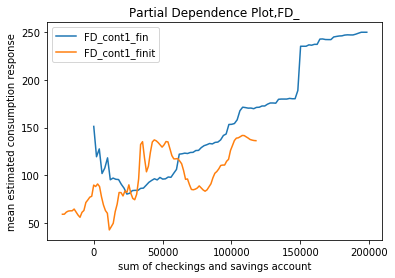

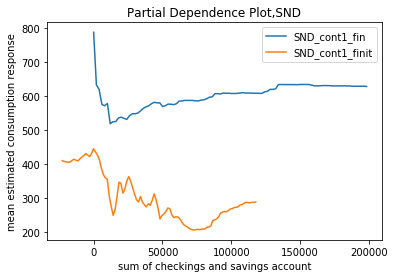

In [47]:
import pandas as pd
import numpy as np
import io
import requests
import os
import zipfile
import urllib.request
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import PercentFormatter #plot as percentage
import seaborn #plot density and histogram at the same time
# Set directory where files are downloaded to. Chdir has to be changed in order to run on another computer
os.chdir('C:\\Users\justu\\Desktop\\Masterarbeit\\Data\\CE')
os.getcwd()

pds_dir = os.listdir(os.getcwd()+'\\pdp')
pds_dir = [s for s in pds_dir if s[-4:]=='.csv']
pds = dict()
pds_dir


for i in pds_dir:
    pds[i[:-4]] = pd.read_csv(os.getcwd()+'\\pdp\\'+ i)
pds
pds_keys = list(pds.keys())

pathlist=[p[:13] for p in pds_keys]
pathlist = list(set(pathlist))
for path in pathlist:
    newpath = os.getcwd() + '\\pdp\\' + path
    if not os.path.exists(newpath):
        os.makedirs(newpath)

#pd.read_csv(os.getcwd()+'\\pdp\\'+ )

var_plot = ['age']
type_plot = ['_mean']
var_plot = ['age','FINCBTXM','FSALARYM','FINCBTAX','orgmrtx_sum','qblncm1x_sum','adults','PERSLT18','morgpayment']
vars_label = ['age', 'tot amount of family income bef taxes', 'income from wages', 'income in last 12 months', 
              'sum of mortgage amounts', 'sum of principal balances outstanding at the beginning of month', 'number of adults', 
              'people below 18 in hh', 'mortgage payment per month']

cons = ['FD_','SND']
#check = [key for key in pds_keys if key[0:7] == 'pdp_' + cons[0]]

for c in cons:
    pds_cons = [key for key in pds_keys if key[0:7] == 'pdp_' + c]
    for var in var_plot:
        for i in pds_cons:
            for j in type_plot:
                plt.plot(pds[i][var+'_grid'], pds[i][var+j], label=i[4:])
        plt.legend()
        plt.xlabel(vars_label[var_plot.index(var)])
        plt.ylabel(j[1:] + ' estimated consumption response')
        plt.title('Partial Dependence Plot,'+ pds_cons[0][4:7])
        plt.savefig(os.getcwd() + '\\pdp\\' + f'{i[:13]}' + f'\\pdp_{var}.pdf')
        plt.show()
   
    
fin_keys = [key for key in pds_keys if key[-5:]!='nofin']

for c in cons:
    fin_cons = [key for key in fin_keys if key[0:7] == 'pdp_' + c]
    for j in type_plot:
        for i in fin_cons:
            if 'finassets_it' + j  in list(pds[i]):
                plt.plot( pds[i]['finassets_it_grid'],pds[i]['finassets_it'+j],label=i[4:])
            else:
                plt.plot(pds[i]['finassets_grid'], pds[i]['finassets'+j],label=i[4:])
        plt.xlabel('sum of checkings and savings account')
        plt.ylabel(j[1:] + ' estimated consumption response')
        plt.title('Partial Dependence Plot,'+ fin_cons[0][4:7])
        plt.legend()
        plt.savefig(os.getcwd() + '\\pdp\\' + f'{i[:13]}' + f'\\pdp_finassets.pdf')
        plt.show()    

**2.7** Visualize tree (not done yet) 

In [44]:
cons = ['FD_','SND']
check = [key for key in pds_keys if key[0:7] == 'pdp_' + cons[0]]
check

['pdp_FD_cont1_fin', 'pdp_FD_cont1_finit', 'pdp_FD_cont1_nofin']

In [10]:
#import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

In [14]:
#pull out one tree from forest
tree = rf.estimators_[5]

#export image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = x_list, rounded = True, precision = 1 )
(graph, )= pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree_check.png')
